# STEP 1: Upload file


In [1]:
from google.colab import files
uploaded = files.upload()


Saving bank-full.csv to bank-full.csv


# STEP 2: Load dataset

In [3]:
# Load CSV (update name if different)
import pandas as pd

df = pd.read_csv('bank-full.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# STEP 3: Data Preprocessing

In [4]:

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Make a copy
data = df.copy()

# Replace 'unknown' with NaN and drop rows with missing values
data.replace('unknown', pd.NA, inplace=True)
data.dropna(inplace=True)

# Encode all categorical columns
label_encoders = {}
for col in data.select_dtypes(include='object').columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Define features (X) and target (y)
X = data.drop('y', axis=1)
y = data['y']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


# STEP 4: Train ML Models

In [5]:
# STEP 4: Train ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC()
}

# Train and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n🔹 {name}")
    print("Accuracy:", round(accuracy_score(y_test, y_pred)*100, 2), "%")
    print(classification_report(y_test, y_pred))



🔹 Logistic Regression
Accuracy: 83.04 %
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      1811
           1       0.68      0.49      0.57       542

    accuracy                           0.83      2353
   macro avg       0.77      0.71      0.73      2353
weighted avg       0.82      0.83      0.82      2353


🔹 Decision Tree
Accuracy: 79.47 %
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1811
           1       0.55      0.56      0.56       542

    accuracy                           0.79      2353
   macro avg       0.71      0.71      0.71      2353
weighted avg       0.80      0.79      0.80      2353


🔹 Random Forest
Accuracy: 84.74 %
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      1811
           1       0.71      0.57      0.63       542

    accuracy                           0.85      2353
   macro avg     

# STEP 5 plot accuracies

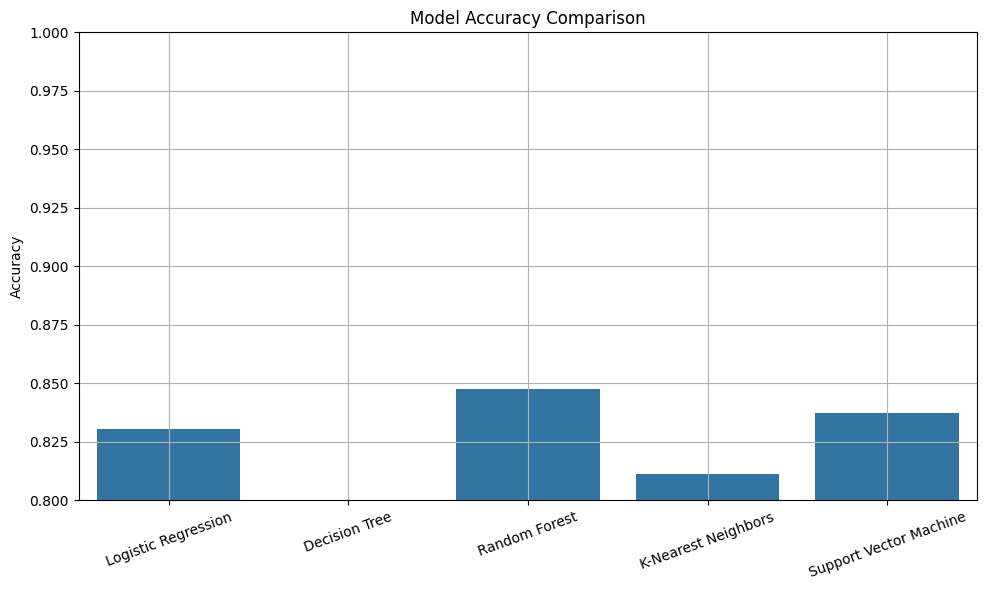

In [7]:
# Plot accuracies
import matplotlib.pyplot as plt
import seaborn as sns

# Get accuracies from the trained models
accuracies = {name: accuracy_score(y_test, model.predict(X_test)) for name, model in models.items()}

plt.figure(figsize=(10,6))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0.80, 1.00)
plt.xticks(rotation=20)
plt.grid(True)
plt.tight_layout()
plt.show()

# STEP 6 Feature importance for Random Forest

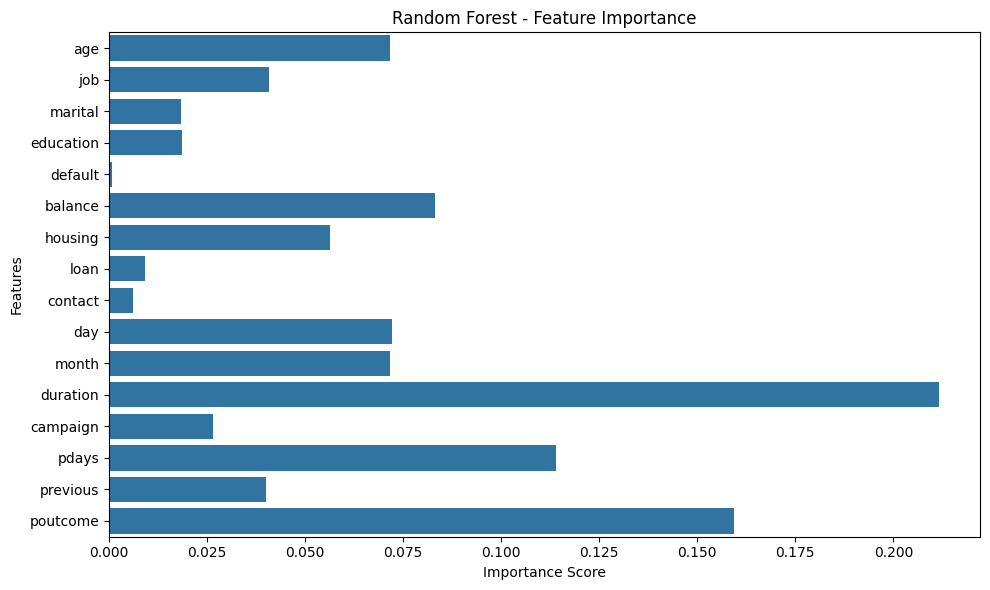

In [8]:

rf_model = models["Random Forest"]
importances = rf_model.feature_importances_
feature_names = X.columns

# Plot top 10 features
plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=feature_names)
plt.title("Random Forest - Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


#  Step 7: Cross-Validation Scores (All Models)

In [9]:
from sklearn.model_selection import cross_val_score
import numpy as np

print("\n🔁 Cross-Validation (5-Fold Mean Accuracy):")
for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=5)
    print(f"{name}: {np.mean(scores):.4f}")



🔁 Cross-Validation (5-Fold Mean Accuracy):
Logistic Regression: 0.8037
Decision Tree: 0.6030
Random Forest: 0.7048
K-Nearest Neighbors: 0.7553
Support Vector Machine: 0.7728


# Step 8: ROC Curve for All Models

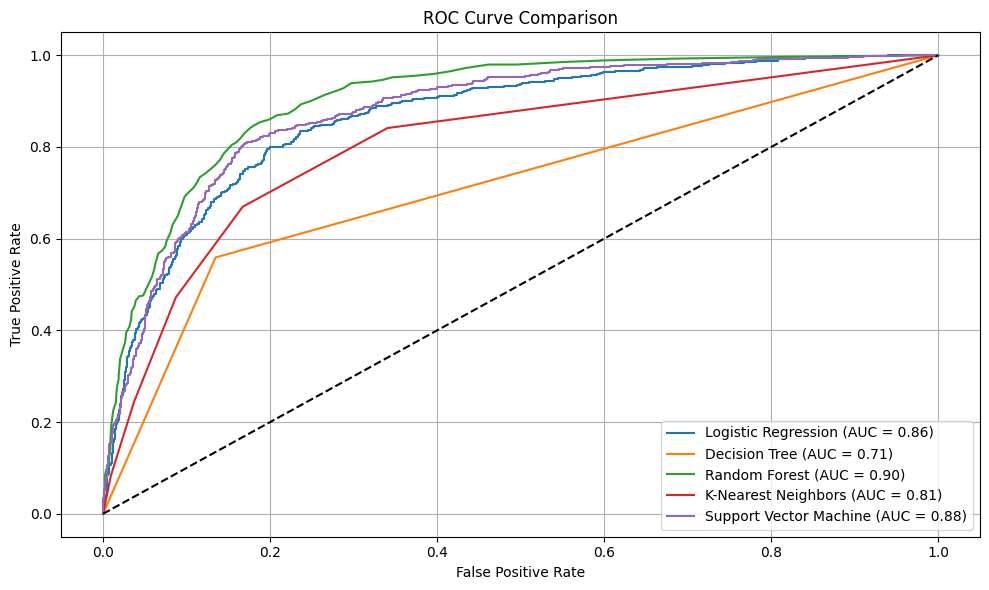

In [10]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize labels
y_bin = label_binarize(y, classes=[0, 1]).ravel()

plt.figure(figsize=(10,6))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        y_score = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
